In [6]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import math
from scipy.optimize import fsolve

In [271]:
def state_price_tree(rate_tree, delta_t, p, n_steps):
    price_tree = np.zeros((n_steps, n_steps))
    price_tree[0, 0] = 1.0
    for n in range(1, n_steps):
        for i in range(n + 1):
            if i == 0:
                price_tree[i, n] = price_tree[i, n - 1] * (1 - p) * np.exp(-rate_tree[i, n - 1] * delta_t)
            elif i == n:
                price_tree[i, n] = price_tree[i - 1, n - 1] * p * np.exp(-rate_tree[i - 1, n - 1] * delta_t)
            else:
                price_tree[i, n] = (price_tree[i - 1, n - 1] * p * np.exp(-rate_tree[i - 1, n - 1] * delta_t) +
                                                price_tree[i, n - 1] * (1 - p) * np.exp(-rate_tree[i, n - 1] * delta_t))
    return price_tree

1
2
3


C:\Users\doret\AppData\Local\Temp\ipykernel_65924\1121407173.py:66: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  sol = fsolve(obj, init_guess, xtol=precision, epsfcn=1e-6)
C:\Users\doret\AppData\Local\Temp\ipykernel_65924\1121407173.py:66: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  sol = fsolve(obj, init_guess, xtol=precision, epsfcn=1e-6)


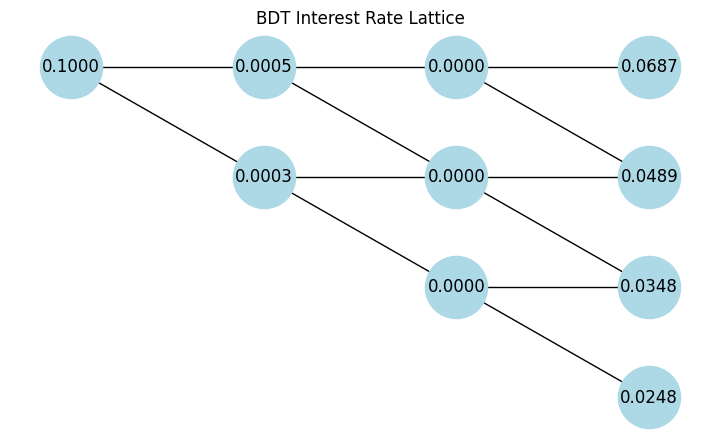

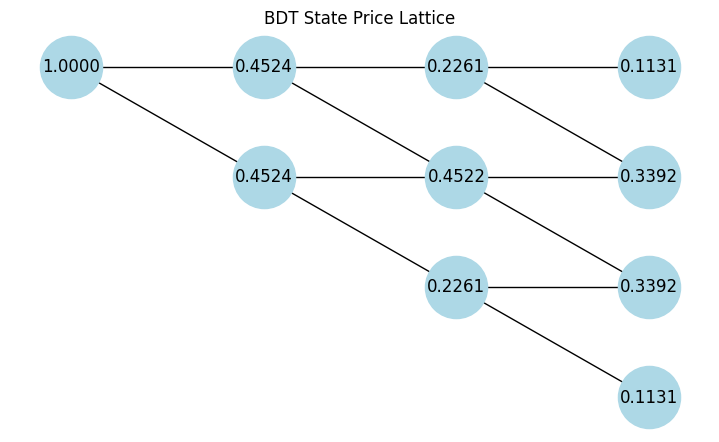

In [373]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

class BDT:
    """
    Simulate the BDT interest rate model.
    Parameters:
    - r0: Initial short rate
    - u: Up factor
    - d: Down factor
    - p: Probability of up movement
    - n_steps: Number of time steps
    - delta_t: Time step size
    Returns:
    - rate_tree: A tree of interest rates
    - state_price_tree: A tree of state prices
    """
    def __init__(self, r0=0.05, u=1.1, d=0.9, p=0.5, n_steps=5, delta_t=1):
        self.n_steps = n_steps
        self.delta_t = delta_t
        self.rate_tree = np.zeros((n_steps, n_steps))
        self.rate_tree[0, 0] = r0
        # Build the interest rate tree
        for n in range(1, n_steps):
            for i in range(n + 1):
                if i == 0:
                    self.rate_tree[i, n] = self.rate_tree[i, n - 1] * d
                else:
                    self.rate_tree[i, n] = self.rate_tree[i - 1, n - 1] * u

        self.state_price_tree = state_price_tree(self.rate_tree, delta_t, p, n_steps)
        self.state_price_tree_U = state_price_tree(self.rate_tree[1:,1:], delta_t, p, n_steps-1)
        self.u = u
        self.d = d
        self.p = p

    def calibrate(self, coupon_rate, volatilities, init_guess=0.5, precision=1e-6):
        """
        Calibrate the BDT interest rate model to bond prices.
        Parameters:
        - coupon_rate: A list of coupon rates
        - volatilities: A list of volatilities
        """
        self.rate_tree[0, 0] = coupon_rate[0]
        for n in range(1, self.n_steps):
            print(n)

            # Set objective function
            def obj(x):
                r = x[0]
                beta = np.exp(2*volatilities[n-1] * np.sqrt(self.delta_t))
                if r < 0:
                    return 10
                rate_tree = self.rate_tree
                for i in range(n + 1):
                    rate_tree[i, n] = r * beta**(-i)
                price_tree = state_price_tree(rate_tree, self.delta_t, self.p, self.n_steps)

                P = np.sum([price_tree[i, n] / (1 + r*beta**i * self.delta_t) for i in range(n)])
                
                T1 = P - (1+coupon_rate[n-1] * self.delta_t)**(-n)
                return T1

            # Solve
            sol = fsolve(obj, init_guess, xtol=precision, epsfcn=1e-6)

            # Update
            rn0 = sol[0]
            for i in range(n + 1):
                self.rate_tree[i, n] = rn0 * np.exp(2*volatilities[n] * np.sqrt(self.delta_t))**(-i)
            self.state_price_tree = state_price_tree(self.rate_tree, self.delta_t, self.p, self.n_steps)

    def simulate(self):
        """
        Simulate the yield curve based on the BDT model.
        Parameters:
        - num_simulations: Number of Monte Carlo simulations
        Returns:
        - yield_curves: Simulated yield curves
        """
        # Simulate short rate paths
        short_rate_path = np.zeros(self.n_steps)
        i = 0
        for n in range(self.n_steps):
            short_rate_path[n] = self.rate_tree[i, n]
            if np.random.rand() < self.p:
                i+=1
        return np.array(short_rate_path)

    def plot_rate(self):
        G = nx.DiGraph()
        for i in range(self.n_steps):
            for j in range(i + 1):
                # Add node with interest rate as label
                G.add_node((i, j), label=f"{self.rate_tree[j, i]:.4f}")
                if i > 0:
                    if j > 0:
                        G.add_edge((i - 1, j - 1), (i, j))
                    if j < i:
                        G.add_edge((i - 1, j), (i, j))

        # Position the nodes in a lattice structure
        pos = {(i, j): (i, -j) for i in range(self.n_steps) for j in range(i + 1)}

        # Draw the graph
        plt.figure(figsize=(7, 4))
        nx.draw(G, pos, with_labels=False, arrows=False, node_size=2000, node_color='lightblue')
        nx.draw_networkx_labels(G, pos, labels={n: d['label'] for n, d in G.nodes(data=True)})
        plt.title("BDT Interest Rate Lattice")
        plt.show()

    def plot_price(self):
        G = nx.DiGraph()
        for i in range(self.n_steps):
            for j in range(i + 1):
                # Add node with interest rate as label
                G.add_node((i, j), label=f"{self.state_price_tree[j, i]:.4f}")
                if i > 0:
                    if j > 0:
                        G.add_edge((i - 1, j - 1), (i, j))
                    if j < i:
                        G.add_edge((i - 1, j), (i, j))

        # Position the nodes in a lattice structure
        pos = {(i, j): (i, -j) for i in range(self.n_steps) for j in range(i + 1)}

        # Draw the graph
        plt.figure(figsize=(7, 4))
        nx.draw(G, pos, with_labels=False, arrows=False, node_size=2000, node_color='lightblue')
        nx.draw_networkx_labels(G, pos, labels={n: d['label'] for n, d in G.nodes(data=True)})
        plt.title("BDT State Price Lattice")
        plt.show()


# Example usage
r0 = 0.1  # Initial short rate
u = 1.1    # Up factor
d = 0.9    # Down factor
p = 0.5    # Probability of up movement
n_steps = 4  # Number of time steps

model = BDT(r0, u, d, p, n_steps, 1)


r = [0.1,0.11,0.12,0.125,0.13]
vol = [0.20,0.19,0.18,0.17,0.16]
model.calibrate(r, vol, 0.11)

model.plot_rate()
model.plot_price()

1
2
3


C:\Users\doret\AppData\Local\Temp\ipykernel_65924\484835390.py:71: RuntimeWarning: divide by zero encountered in scalar power
  T2 = un**(-1/n) - 1 - (vn**(-1/n) - 1)*np.exp(2*volatilities[n-1] * np.sqrt(self.delta_t))
C:\Users\doret\AppData\Local\Temp\ipykernel_65924\484835390.py:75: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  sol = fsolve(obj, init_guess, xtol=precision, epsfcn=1e-6)


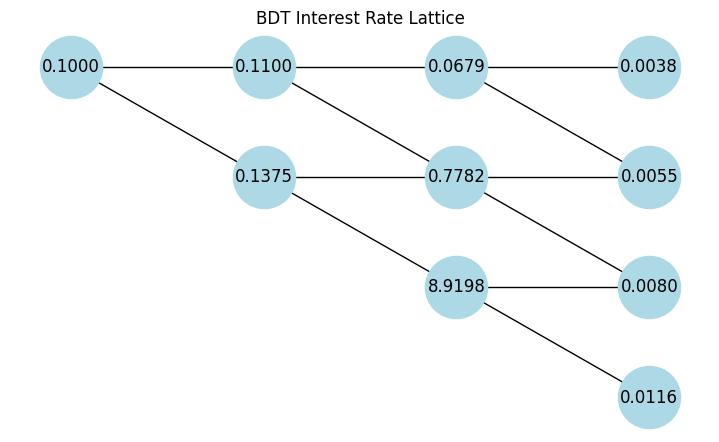

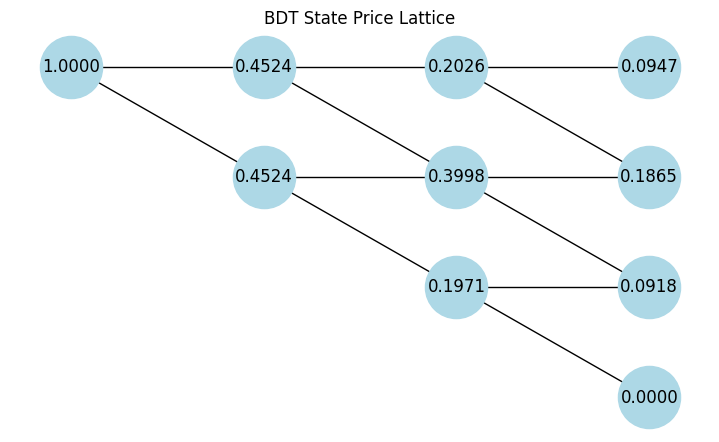

In [387]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

class BDT:
    """
    Simulate the BDT interest rate model.
    Parameters:
    - r0: Initial short rate
    - u: Up factor
    - d: Down factor
    - p: Probability of up movement
    - n_steps: Number of time steps
    - delta_t: Time step size
    Returns:
    - rate_tree: A tree of interest rates
    - state_price_tree: A tree of state prices
    """
    def __init__(self, r0=0.05, u=1.1, d=0.9, p=0.5, n_steps=5, delta_t=1):
        self.n_steps = n_steps
        self.delta_t = delta_t
        self.rate_tree = np.zeros((n_steps, n_steps))
        self.rate_tree[0, 0] = r0
        # Build the interest rate tree
        for n in range(1, n_steps):
            for i in range(n + 1):
                if i == 0:
                    self.rate_tree[i, n] = self.rate_tree[i, n - 1] * d
                else:
                    self.rate_tree[i, n] = self.rate_tree[i - 1, n - 1] * u

        self.state_price_tree = state_price_tree(self.rate_tree, delta_t, p, n_steps)
        self.state_price_tree_U = state_price_tree(self.rate_tree[1:,1:], delta_t, p, n_steps-1)
        self.u = u
        self.d = d
        self.p = p
        
    def update_price_tree(self):
        spt = state_price_tree(self.rate_tree, self.delta_t, self.p, self.n_steps)
        sptU = state_price_tree(self.rate_tree[1:,1:], self.delta_t, self.p, self.n_steps-1)
        return spt, sptU

    def calibrate(self, coupon_rate, volatilities, init_guess=[0.5, 1], precision=1e-6):
        """
        Calibrate the BDT interest rate model to bond prices.
        Parameters:
        - coupon_rate: A list of coupon rates
        - volatilities: A list of volatilities
        """
        self.rate_tree[0, 0] = coupon_rate[0]
        for n in range(1, self.n_steps):
            print(n)

            # Set objective function
            def obj(x):
                r, beta = x[0], x[1]
                if r < 0 or beta < 0:
                    return [10, 10]
                rate_tree = self.rate_tree
                for i in range(n + 1):
                    rate_tree[i, n] = r * beta**(-i)
                # price_tree, price_tree_U = self.update_price_tree()
                price_tree = state_price_tree(rate_tree, self.delta_t, self.p, self.n_steps)
                price_tree_U = state_price_tree(rate_tree[1:,1:], self.delta_t, self.p, self.n_steps-1)

                P = np.sum([price_tree[i, n] / (1 + r*beta**i * self.delta_t) for i in range(n)])
                un = np.sum([price_tree_U[i, n-1]/(1 + r*beta**i * self.delta_t) for i in range(1, n)])
                vn = 2*(1+coupon_rate[n] * self.delta_t)**(-1)/(1+coupon_rate[1] * self.delta_t)**(-1) - un
                
                T1 = P - (1+coupon_rate[n-1] * self.delta_t)**(-n)
                T2 = un**(-1/n) - 1 - (vn**(-1/n) - 1)*np.exp(2*volatilities[n-1] * np.sqrt(self.delta_t))
                return [T1, T2]

            # Solve
            sol = fsolve(obj, init_guess, xtol=precision, epsfcn=1e-6)

            # Update
            rn0, betan = sol[0], sol[1]
            for i in range(n + 1):
                self.rate_tree[i, n] = rn0 * betan**(-i)
            self.state_price_tree, self.state_price_tree_U = self.update_price_tree()

    def simulate(self):
        """
        Simulate the yield curve based on the BDT model.
        Parameters:
        - num_simulations: Number of Monte Carlo simulations
        Returns:
        - yield_curves: Simulated yield curves
        """
        # Simulate short rate paths
        short_rate_path = np.zeros(self.n_steps)
        i = 0
        for n in range(self.n_steps):
            short_rate_path[n] = self.rate_tree[i, n]
            if np.random.rand() < self.p:
                i+=1
        return np.array(short_rate_path)

    def plot_rate(self):
        G = nx.DiGraph()
        for i in range(self.n_steps):
            for j in range(i + 1):
                # Add node with interest rate as label
                G.add_node((i, j), label=f"{self.rate_tree[j, i]:.4f}")
                if i > 0:
                    if j > 0:
                        G.add_edge((i - 1, j - 1), (i, j))
                    if j < i:
                        G.add_edge((i - 1, j), (i, j))

        # Position the nodes in a lattice structure
        pos = {(i, j): (i, -j) for i in range(self.n_steps) for j in range(i + 1)}

        # Draw the graph
        plt.figure(figsize=(7, 4))
        nx.draw(G, pos, with_labels=False, arrows=False, node_size=2000, node_color='lightblue')
        nx.draw_networkx_labels(G, pos, labels={n: d['label'] for n, d in G.nodes(data=True)})
        plt.title("BDT Interest Rate Lattice")
        plt.show()

    def plot_price(self):
        G = nx.DiGraph()
        for i in range(self.n_steps):
            for j in range(i + 1):
                # Add node with interest rate as label
                G.add_node((i, j), label=f"{self.state_price_tree[j, i]:.4f}")
                if i > 0:
                    if j > 0:
                        G.add_edge((i - 1, j - 1), (i, j))
                    if j < i:
                        G.add_edge((i - 1, j), (i, j))

        # Position the nodes in a lattice structure
        pos = {(i, j): (i, -j) for i in range(self.n_steps) for j in range(i + 1)}

        # Draw the graph
        plt.figure(figsize=(7, 4))
        nx.draw(G, pos, with_labels=False, arrows=False, node_size=2000, node_color='lightblue')
        nx.draw_networkx_labels(G, pos, labels={n: d['label'] for n, d in G.nodes(data=True)})
        plt.title("BDT State Price Lattice")
        plt.show()


# Example usage
r0 = 0.1  # Initial short rate
u = 1.1    # Up factor
d = 0.9    # Down factor
p = 0.5    # Probability of up movement
n_steps = 4  # Number of time steps

model = BDT(r0, u, d, p, n_steps, 1)


r = [0.1,0.11,0.12,0.125,0.13]
vol = [0.20,0.19,0.18,0.17,0.16]
model.calibrate(r, vol, [0.11, 0.8])

model.plot_rate()
model.plot_price()

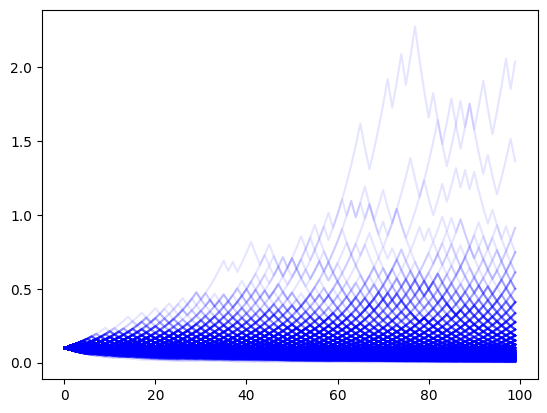

In [358]:
# Example usage
r0 = 0.1  # Initial short rate
u = 1.1    # Up factor
d = 0.9    # Down factor
p = 0.5    # Probability of up movement
n_steps = 100  # Number of time steps
delta_t = 0.25  # Time step size
n_simulations = 1000  # Number of Monte Carlo simulations

model = BDT(r0, u, d, p, n_steps, delta_t)

for i in range(n_simulations):
    short_rate_curve = model.simulate()
    plt.plot(short_rate_curve, color='blue', alpha=0.1)

In [367]:
# Example usage
u = 1.1    # Up factor
d = 0.9    # Down factor
p = 0.5    # Probability of up movement
max_n_steps = 120  # Number of time steps
delta_t = 0.25  # Time step size
n_simulations = 10000  # Number of Monte Carlo simulations

# 0.05 rate
r0 = 0.05  # Initial short rate
m1_l5_cst, m2_l5_cst = [], []
for n_steps in range(3, max_n_steps):
    model = BDT(r0, 1, 1, p, n_steps, 1/n_steps)
    B_l = [np.prod(1+model.simulate()*delta_t) for _ in range(n_simulations)]
    m1_l5_cst.append(np.mean(B_l))
    m2_l5_cst.append(np.mean([B**2 for B in B_l]))

m1_l5, m2_l5 = [], []
for n_steps in range(3, max_n_steps):
    model = BDT(r0, u, d, p, n_steps, 1/n_steps)
    B_l = [np.prod(1+model.simulate()*delta_t) for _ in range(n_simulations)]
    m1_l5.append(np.mean(B_l))
    m2_l5.append(np.mean([B**2 for B in B_l]))

# 0.025 rate
r0 = 0.025  # Initial short rate
m1_l25_cst, m2_l25_cst = [], []
for n_steps in range(3, max_n_steps):
    model = BDT(r0, 1, 1, p, n_steps, 1/n_steps)
    B_l = [np.prod(1+model.simulate()*delta_t) for _ in range(n_simulations)]
    m1_l25_cst.append(np.mean(B_l))
    m2_l25_cst.append(np.mean([B**2 for B in B_l]))

m1_l25, m2_l25 = [], []
for n_steps in range(3, max_n_steps):
    model = BDT(r0, u, d, p, n_steps, 1/n_steps)
    B_l = [np.prod(1+model.simulate()*delta_t) for _ in range(n_simulations)]
    m1_l25.append(np.mean(B_l))
    m2_l25.append(np.mean([B**2 for B in B_l]))

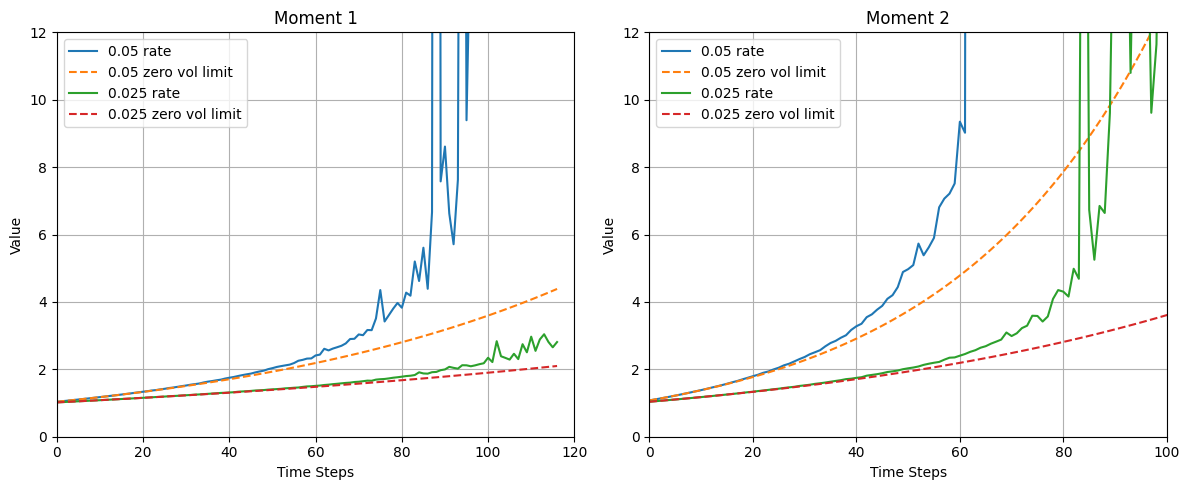

In [368]:
# Plot the results
plt.figure(figsize=(12, 5))

# Plot Libor Rates
plt.subplot(1, 2, 1)
plt.ylim(0, 12)
plt.xlim(0, max_n_steps)
plt.plot(m1_l5, label='0.05 rate')
plt.plot(m1_l5_cst, label='0.05 zero vol limit', linestyle='--')
plt.plot(m1_l25, label='0.025 rate')
plt.plot(m1_l25_cst, label='0.025 zero vol limit', linestyle='--')
plt.title('Moment 1')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

# Plot Money Market Account
plt.subplot(1, 2, 2)
plt.ylim(0, 12)
plt.xlim(0, max_n_steps/1.2)
plt.plot(m2_l5, label='0.05 rate')
plt.plot(m2_l5_cst, label='0.05 zero vol limit', linestyle='--')
plt.plot(m2_l25, label='0.025 rate')
plt.plot(m2_l25_cst, label='0.025 zero vol limit', linestyle='--')
plt.title('Moment 2')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [370]:
class BlackDermanToy:
    def __init__(self, r0, u, d, p, n_steps, delta):
        """
        Initialize the Black-Derman-Toy model.

        Parameters:
        - r0: Initial short rate.
        - u: Up factor.
        - d: Down factor.
        - p: Probability of an up move.
        - n_steps: Number of steps in the simulation.
        - delta: Time step size.
        """
        self.r0 = r0
        self.u = u
        self.d = d
        self.p = p
        self.n_steps = n_steps
        self.delta = delta

    def simulate(self):
        """
        Simulate a short rate path using the Black-Derman-Toy model.

        Returns:
        - A numpy array representing the short rate path.
        """
        short_rate_path = np.zeros(self.n_steps + 1)
        short_rate_path[0] = self.r0

        for i in range(1, self.n_steps + 1):
            if np.random.rand() < self.p:
                short_rate_path[i] = short_rate_path[i - 1] * self.u
            else:
                short_rate_path[i] = short_rate_path[i - 1] * self.d

        return short_rate_path

In [371]:
# Example usage
u = 1.1    # Up factor
d = 0.9    # Down factor
p = 0.5    # Probability of up movement
max_n_steps = 120  # Number of time steps
delta_t = 0.25  # Time step size
n_simulations = 10000  # Number of Monte Carlo simulations

# 0.05 rate
r0 = 0.05  # Initial short rate
m1_l5_cst, m2_l5_cst = [], []
for n_steps in range(3, max_n_steps):
    model = BlackDermanToy(r0, 1, 1, p, n_steps, 1/n_steps)
    B_l = [np.prod(1+model.simulate()*delta_t) for _ in range(n_simulations)]
    m1_l5_cst.append(np.mean(B_l))
    m2_l5_cst.append(np.mean([B**2 for B in B_l]))

m1_l5, m2_l5 = [], []
for n_steps in range(3, max_n_steps):
    model = BlackDermanToy(r0, u, d, p, n_steps, 1/n_steps)
    B_l = [np.prod(1+model.simulate()*delta_t) for _ in range(n_simulations)]
    m1_l5.append(np.mean(B_l))
    m2_l5.append(np.mean([B**2 for B in B_l]))

# 0.025 rate
r0 = 0.025  # Initial short rate
m1_l25_cst, m2_l25_cst = [], []
for n_steps in range(3, max_n_steps):
    model = BlackDermanToy(r0, 1, 1, p, n_steps, 1/n_steps)
    B_l = [np.prod(1+model.simulate()*delta_t) for _ in range(n_simulations)]
    m1_l25_cst.append(np.mean(B_l))
    m2_l25_cst.append(np.mean([B**2 for B in B_l]))

m1_l25, m2_l25 = [], []
for n_steps in range(3, max_n_steps):
    model = BlackDermanToy(r0, u, d, p, n_steps, 1/n_steps)
    B_l = [np.prod(1+model.simulate()*delta_t) for _ in range(n_simulations)]
    m1_l25.append(np.mean(B_l))
    m2_l25.append(np.mean([B**2 for B in B_l]))

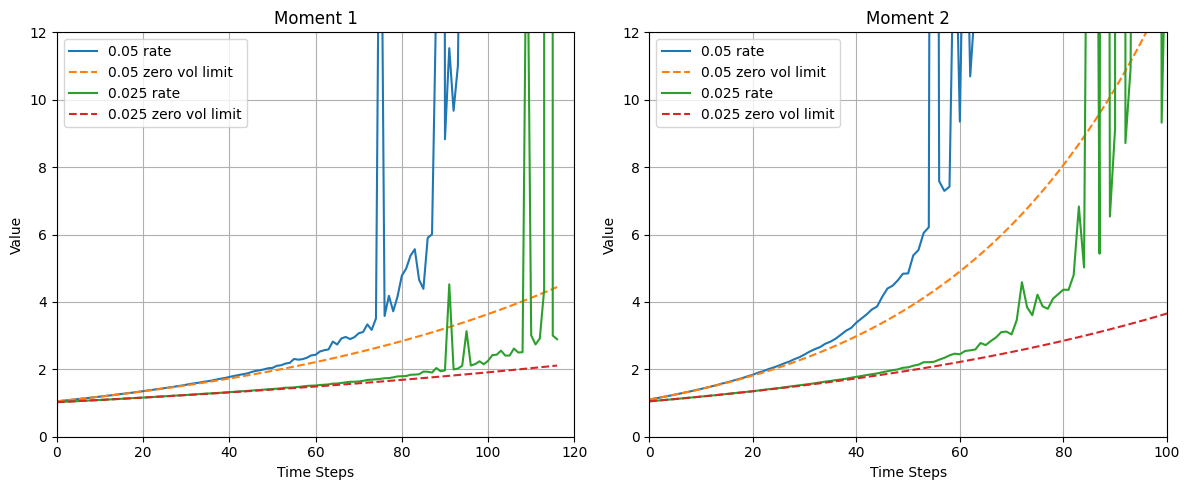

In [372]:
# Plot the results
plt.figure(figsize=(12, 5))

# Plot Libor Rates
plt.subplot(1, 2, 1)
plt.ylim(0, 12)
plt.xlim(0, max_n_steps)
plt.plot(m1_l5, label='0.05 rate')
plt.plot(m1_l5_cst, label='0.05 zero vol limit', linestyle='--')
plt.plot(m1_l25, label='0.025 rate')
plt.plot(m1_l25_cst, label='0.025 zero vol limit', linestyle='--')
plt.title('Moment 1')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

# Plot Money Market Account
plt.subplot(1, 2, 2)
plt.ylim(0, 12)
plt.xlim(0, max_n_steps/1.2)
plt.plot(m2_l5, label='0.05 rate')
plt.plot(m2_l5_cst, label='0.05 zero vol limit', linestyle='--')
plt.plot(m2_l25, label='0.025 rate')
plt.plot(m2_l25_cst, label='0.025 zero vol limit', linestyle='--')
plt.title('Moment 2')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()